# Lagrangian trajectories in the Gulf Stream area: movies



In [1]:
# import libraries

%matplotlib inline
import os, shutil
from glob import glob
import re
#from netCDF4 import Dataset
#import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import gsw

from clib.flow import *

In [2]:
# load grid info
grd = grid()

# output files
ofiles = sorted(glob(grd._datadir+'*avg*.nc'))

ds = xr.open_mfdataset(ofiles, concat_dim='time', compat='equals')
print(ds)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 1602, eta_v: 1601, s_rho: 50, s_w: 51, time: 1300, xi_rho: 2002, xi_u: 2001)
Coordinates:
  * time        (time) float64 6.48e+07 6.481e+07 6.481e+07 6.481e+07 ...
Dimensions without coordinates: auxil, eta_rho, eta_v, s_rho, s_w, xi_rho, xi_u
Data variables:
    time_step   (time, auxil) int32 dask.array<shape=(1300, 4), chunksize=(20, 4)>
    scrum_time  (time) float32 dask.array<shape=(1300,), chunksize=(20,)>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<shape=(1300, 1602, 2002), chunksize=(20, 1602, 2002)>
    ubar        (time, eta_rho, xi_u) float32 dask.array<shape=(1300, 1602, 2001), chunksize=(20, 1602, 2001)>
    vbar        (time, eta_v, xi_rho) float32 dask.array<shape=(1300, 1601, 2002), chunksize=(20, 1

In [3]:
ldatadir = '/home/datawork-lops-osi/jgula/Cognac/north/'
lfiles = sorted(glob(ldatadir+'*.nc'))

# open files
lds = [xr.open_dataset(file) for file in lfiles]
print(lds[0])

dt_particles = lds[0].ocean_time[1]-lds[0].ocean_time[0]
print('dt_particles = %.1f' %dt_particles)

depth = [-l.depth for l in lds]
print('depth of different simulations:' , depth)

# convert list of datasets into a dict of datasets
lds = dict(zip(depth,lds))

# conmpute the offset between ds.time and lds.ocean_time
dt = find_dt(lds[0], ds, ofiles)
# ds.time/86400. = (d.ocean_time+dt)/86400.

<xarray.Dataset>
Dimensions:     (nq: 10037, time: 360)
Coordinates:
  * time        (time) float32 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 ...
Dimensions without coordinates: nq
Data variables:
    ocean_time  (time) float32 ...
    px          (time, nq) float64 ...
    py          (time, nq) float64 ...
    pt          (time, nq) float64 ...
    ps          (time, nq) float64 ...
    pu          (time, nq) float64 ...
    pv          (time, nq) float64 ...
    plon        (time, nq) float64 ...
    plat        (time, nq) float64 ...
    ptopo       (time, nq) float64 ...
    prho        (time, nq) float64 ...
    prho1       (time, nq) float64 ...
Attributes:
    description:  particles tracking
    simulation:   nesed_avg [0,10000,0,10000,[1,100,1]] 60
    sub:          360
    base:         0
    ng:           1
    x_periodic:   0
    y_periodic:   0
    depth:        0
dt_particles = 3600.0
depth of different simulations: [0, 50, 100, 200, 300, 400, 500]


In [4]:
# useful parameters

# initial mass center
lon0, lat0 = lds[0].plon.isel(time=0).mean().values, lds[0].plat.isel(time=0).mean().values
# metric terms
dlon = 111.e3 * np.cos(np.pi/180.*lat0)
dlat = 111.e3

nq = {}
for d in [2, 5, 10, 20]:
    sources = []
    sources.append([-d*1.e3, -d*1.e3])
    sources.append([-d*1.e3, d*1.e3])
    sources.append([d*1.e3, d*1.e3])
    sources.append([d*1.e3, -d*1.e3])
    nq[d] = np.array([get_nq( lds[0], lon0+s[0]/dlon, lat0+s[1]/dlat ) for s in sources])

# colors
cols = cm.plasma(np.linspace(0,1,len(nq)))
cols = dict(zip(nq.keys(),[cols[i,:] for i in range(cols.shape[0])]))

---

## Initial position

Text(0.5,1,'surface temperature [degC]')

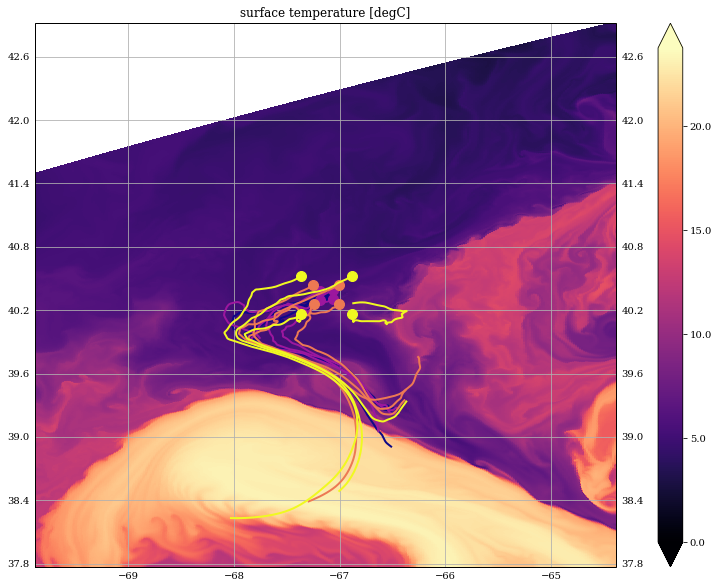

In [5]:
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
#ax.set_extent(grd.hextent, crs)
ax.set_extent(get_hextent(lds[0].isel(time=0), dlon=2., dlat=2.), crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
iz = -1
ilon = int(grd.Lp/2)  # used for vertical slices
toplt = ds['temp'].isel(time=0, s_rho=iz).values
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap, transform=crs)
cbar = plt.colorbar(im, format='%.1f', extend='both')


for d in [2, 5, 10, 20]:
    l = lds[0].isel(nq=nq[d]).isel(time=slice(0,24*10))
    ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color=cols[d], markersize=10, transform=crs)
    ax.plot(l.plon,l.plat, color=cols[d], lw=2, transform=crs)

#l = lds[0].isel(nq=nq[10]).isel(time=slice(0,24*10))
#ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color='0.5', transform=crs)
#ax.plot(l.plon,l.plat, color='0.5', transform=crs)

ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

## at a given time

In [6]:
# potentially need to resample SST data, here both are hourly
#ds = ds.resample(time=dt)
# and then interp
print('dt parcels : %0.f s' %dt_particles)
print('dt avg outputs : %0.f s' %(ds.time[1]-ds.time[0]))


dt parcels : 3600 s
dt avg outputs : 3600 s


Text(0.5,1,'surface temperature [degC]')

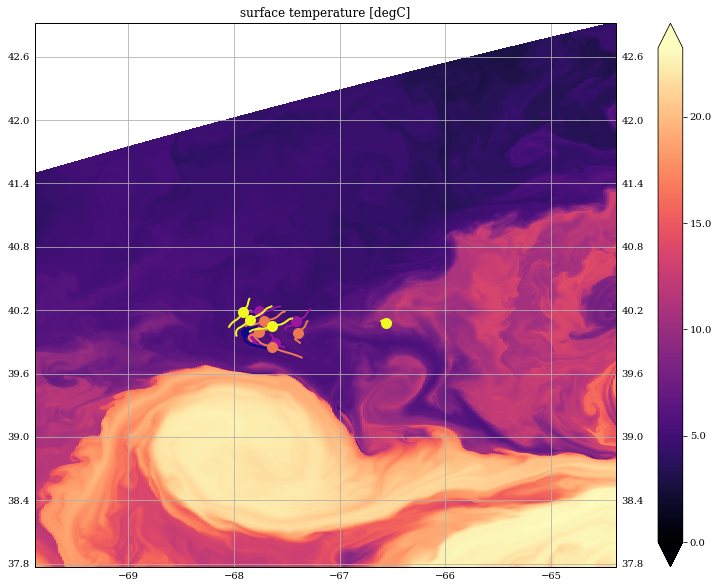

In [7]:
it = 100
t = lds[0].isel(time=it).ocean_time
# ds.time/86400. = (lds.ocean_time+dt)/86400.

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
#ax.set_extent(grd.hextent, crs)
ax.set_extent(get_hextent(lds[0].isel(time=0), dlon=2., dlat=2.), crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
iz = -1
ilon = int(grd.Lp/2)  # used for vertical slices
toplt = ds['temp'].isel(s_rho=iz).sel(time=t+dt).values
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap, transform=crs)
cbar = plt.colorbar(im, format='%.1f', extend='both')


for d in [2, 5, 10, 20]:
    l = lds[0].isel(nq=nq[d])
    ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'o', color=cols[d], markersize=10, transform=crs)
    ax.plot(l.plon.isel(time=slice(it-24,it+24)),l.plat.isel(time=slice(it-24,it+24)), \
            color=cols[d], lw=2, transform=crs)

#l = lds[0].isel(nq=nq[10]).isel(time=slice(0,24*10))
#ax.plot(l.plon.isel(time=0),l.plat.isel(time=0),'o', color='0.5', transform=crs)
#ax.plot(l.plon,l.plat, color='0.5', transform=crs)

ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)

---

## loop over time to create movie

In [8]:
ti = lds[0].ocean_time.values

figdir = '/home2/pharos/othr/aponte/figs/'
shutil.rmtree(figdir, ignore_errors=True); os.mkdir(figdir)

plt.switch_backend('agg')

for it, t in enumerate(ti):
        
    fig=plt.figure(figsize=(15,10))
    
    #
    ax=plt.axes(projection=crs)
    #ax.set_extent(grd.hextent, crs)
    ax.set_extent(get_hextent(lds[0].isel(time=it), dlon=1., dlat=1.), crs)
    gl=ax.gridlines(crs=crs,draw_labels=True)
    gl.xlabels_top = False
    ax.coastlines(resolution='50m')
    #
    iz = -1
    ilon = int(grd.Lp/2)  # used for vertical slices
    toplt = ds['temp'].isel(s_rho=iz).sel(time=t+dt).values
    cmap = plt.get_cmap('magma')
    im = ax.pcolormesh(grd['lon_rho'],grd['lat_rho'], toplt,
                       vmin=toplt.min(),vmax=toplt.max(), 
                       cmap=cmap, transform=crs)
    cbar = plt.colorbar(im, format='%.1f', extend='both')

    # floats
    if True:
        l = lds[200]
        ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'.', color='w', \
                markersize=1, transform=crs)
        
    # plot sources
    for d in [2, 5, 10, 20]:
        l = lds[0].isel(nq=nq[d])
        ax.plot(l.plon.isel(time=it),l.plat.isel(time=it),'o', color=cols[d], \
                markersize=10, transform=crs)
        if it>1:
            ax.plot(l.plon.isel(time=slice(max(it-24,0),it)), \
                    l.plat.isel(time=slice(max(it-24,0),it)), \
                    color=cols[d], lw=2, transform=crs)
    
    # plot scale
    plot_scale(ax, 10.e3, y_offset=0., color='.8')
    plot_scale(ax, 100.e3, y_offset=0.1, color='.8')
            
    ax.set_title('t = %0.2f d'%(t/86400.))

    plt.savefig(figdir+'sst_ltraj_%03d.png'%it, dpi=150)
    plt.close(fig)
    
    print('%d / %d'%(it, ti.size-1))


0 / 360
1 / 360
2 / 360
3 / 360
4 / 360
5 / 360
6 / 360
7 / 360
8 / 360
9 / 360
10 / 360
11 / 360
12 / 360
13 / 360
14 / 360
15 / 360
16 / 360
17 / 360
18 / 360
19 / 360
20 / 360
21 / 360
22 / 360
23 / 360
24 / 360
25 / 360
26 / 360
27 / 360
28 / 360
29 / 360
30 / 360
31 / 360
32 / 360
33 / 360
34 / 360
35 / 360
36 / 360
37 / 360
38 / 360
39 / 360
40 / 360
41 / 360
42 / 360
43 / 360
44 / 360
45 / 360
46 / 360
47 / 360
48 / 360
49 / 360
50 / 360
51 / 360
52 / 360
53 / 360
54 / 360
55 / 360
56 / 360
57 / 360
58 / 360
59 / 360
60 / 360
61 / 360
62 / 360
63 / 360
64 / 360
65 / 360
66 / 360
67 / 360
68 / 360
69 / 360
70 / 360
71 / 360
72 / 360
73 / 360
74 / 360
75 / 360
76 / 360
77 / 360
78 / 360
79 / 360
80 / 360
81 / 360
82 / 360
83 / 360
84 / 360
85 / 360
86 / 360
87 / 360
88 / 360
89 / 360
90 / 360
91 / 360
92 / 360
93 / 360
94 / 360
95 / 360
96 / 360
97 / 360
98 / 360
99 / 360
100 / 360
101 / 360
102 / 360
103 / 360
104 / 360
105 / 360
106 / 360
107 / 360
108 / 360
109 / 360
110 / 360
